In [1]:
import sys
print(sys.executable)

/home/ubuntu/miniconda3/envs/llm/bin/python


In [1]:
base_url = "https://www.nhs.uk/start-for-life/pregnancy/week-by-week-guide-to-pregnancy/"
trimester = {
    1: {
        "url": "1st-trimester/week-",
        "weeks": list(range(4, 13))
    },
    2: {
        "url": "2nd-trimester/week-",
        "weeks": list(range(13, 28))
    },
    3: {
        "url": "3rd-trimester/week-",
        "weeks": list(range(28, 42))
    }
}

import requests
from bs4 import BeautifulSoup
from langchain.docstore.document import Document

def url_builder(week: int):
    if week < 4 or week > 41:
        raise ValueError("Week out of bound!")
    target = [key for key, subdict in trimester.items() if week in subdict.get("weeks", [])][0]
    return base_url + trimester[target]['url'] + str(week) + '/'

def scrape_week_content(week_number: int):
    docs = []

    response = requests.get(url_builder(week_number))
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        intro = soup.select_one("#maincontent > section:first-of-type div.nhsuk-u-reading-width")
        if intro:
            doc = Document(
                page_content=intro.get_text(separator=" ", strip=True),
                metadata={"week": week_number, "section": "intro"}
            )
            docs.append(doc)
        else:
            print("Intro not found.")

        start_section = soup.find("section", id="whats-happening")
        end_section = soup.find("section", id="action-stations")
        
        current_section = start_section if start_section else None
        
        while current_section:
            section_id = current_section.get("id")
            if not section_id:
                heading_tag = current_section.find(["h1", "h2", "h3", "h4", "h5", "h6"])
                if heading_tag:
                    section_id = heading_tag.get_text(strip=True)
                else:
                    section_id = "No ID"
            doc = Document(
                page_content=current_section.get_text(separator=" ", strip=True),
                metadata={"week": week_number, "section": section_id}
            )
            docs.append(doc)
            if current_section == end_section:
                break  # Stop after including the end section
            current_section = current_section.find_next_sibling("section")
    else:
        print(f"Failed to fetch page. Status code: {response.status_code}")

    return docs

In [2]:
all_docs = []

for week in range(4, 42):
    all_docs.extend(scrape_week_content(week))

In [3]:
all_docs[0]

Document(metadata={'week': 4, 'section': 'intro'}, page_content="Week 4 To the outside world, you'll look much the same as usual – but on the inside, your embryo is about the size of a poppy seed and some amazing things are happening. For information on your pregnancy journey, sign up for regular emails tailored to your stage of pregnancy or baby's age.")

In [2]:
from langchain.docstore.document import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

embeddings_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
try:
    # This will fail if all_docs is not defined
    vectordb = FAISS.from_documents(all_docs, embeddings_model)
    vectordb.save_local("../data/vectordb")
except NameError:
    # all_docs is undefined, so load the FAISS index instead
    vectordb = FAISS.load_local("../data/vectordb", embeddings_model, allow_dangerous_deserialization=True)

In [3]:
import re

def search(query, vectordb=vectordb, k=20):
    # Perform similarity search
    results = vectordb.similarity_search_with_score(query, k=k)
    return results
    

def search_filter(results_with_score=None, vectordb=vectordb, week_filter=None, section_filter=None):
    documents = results_with_score or [(doc, None) for doc in vectordb.docstore._dict.values()]
    return [
        (doc, score) for doc, score in documents
        if (week_filter is None or doc.metadata.get("week") == week_filter)
        and (section_filter is None or doc.metadata.get("section") == section_filter)
    ]

def get_content_by_week(week: int, vectordb=vectordb):
    docs = search_filter(week_filter=week, vectordb=vectordb)
    result = ""
    line = "=" * 50

    for doc, score in docs:
        title = f"\nWEEK: {doc.metadata['week']}; SECTION: {doc.metadata['section']}\n\n"
        content = doc.page_content

        result += "\n" + line + title + re.sub(r'([.!?])\s*', r'\1\n', content) + line

    return result

In [10]:
# All sections
print(set([doc[0].metadata['section'] for doc in search_filter()]))

{'due', 'blues', 'gaining-weight', 'intro', 'RSV vaccination', 'sling-safety', 'signs-of-labour', 'home-birth', 'look-like', 'alcohol', '2nd-trimester-pregnancy-signs', 'Whooping cough vaccination', 'constipation', 'gas', 'births', 'early-pregnancy-signs', 'maternity-service', 'stretch-marks', '8-tips', '7-things', 'feeding', 'pregnant', 'Strange symptoms', 'whats-happening', 'Carbon monoxide alert', 'boy-or-girl', 'contact', 'teeth', 'RSV-vaccination', 'how-should-I-sleep-in-pregnancy?', 'certificate', 'diet', 'sleep', 'single-parent', 'induced-labour', 'pants', 'movements', 'vaginal-after-caesarean', 'scan', 'action-stations', 'maternity-leave', 'cravings', 'prescriptions', 'nausea', 'whooping-cough', '9-signs', 'clothes', 'nosebleeds', 'sun', 'talk', 'flying', 'sleeping-positions', 'Super snacks', 'bring-on-labour', '3rd-trimester-pregnancy-signs', 'bloating', 'jabs', 'infection', 'group-b-strep', 'thrush', 'vit-k', 'firstscan', 'quit-smoking', 'prep', 'pain-management', 'Eye eye!',

In [ ]:
search("when to go to hospital", vectordb=vectordb)

In [11]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from dotenv import load_dotenv
import os

load_dotenv()

llm = ChatOpenAI(
  openai_api_key=os.getenv("API_KEY"),
  openai_api_base="https://openrouter.ai/api/v1",
  model_name="deepseek/deepseek-r1"
)


In [13]:
template = """
Question: {question}

Context: {context}

Answer: Let's think step by step.
"""
input_variables = ["question", "context"]
query = {
    "question": "what I need to do", 
    "context": get_content_by_week(10)
}

In [17]:
prompt = PromptTemplate(template=template, input_variables=input_variables)
llm_chain = prompt | llm

output = []
for chunk in llm_chain.stream(query):
    print(chunk.content, end="", flush=True)
    output.append(chunk.content)
final_output = "".join(output)

**What You Need to Do at 10 Weeks Pregnant**  

### **Medical Appointments**  
1. **Schedule/Attend Booking Appointment**:  
   - Arrange with your midwife/GP (between weeks 8–12). Discuss pregnancy options, birth plans, and screening tests (e.g., Down’s syndrome, infections).  
   - Ask about continuity of care (seeing the same carer throughout pregnancy).  

2. **First Dating Scan**:  
   - Schedule between weeks 8–14 to monitor baby’s growth and confirm due date.  

---

### **Lifestyle Adjustments**  
- **Avoid Harmful Substances**:  
  - Quit smoking and alcohol; reduce caffeine (tea, coffee, energy drinks). Seek support from your midwife/GP.  
- **Antenatal Classes**:  
  - Enroll in online or local classes (e.g., NCT) to prepare for birth and connect with others.  

---

### **Diet & Supplements**  
- **Prenatal Vitamins**:  
  - **Folic Acid**: 400mcg daily until at least week 12 to support baby’s nervous system.  
  - **Vitamin D**: 10mcg daily, especially October–March (or ye

In [15]:
print(final_output)

**What You Need to Do During Week 10 of Pregnancy**  

### 1. **Medical Appointments & Planning**  
- **Schedule a Booking Appointment**: Contact your midwife or GP (or self-refer via your local hospital's website). This 1-hour appointment (ideally done by week 12) includes:  
  - Screening tests for infections and conditions like Down’s syndrome.  
  - Discussions about pregnancy/birth options.  
  - Inquiring about the *Maternity Transformation Programme* for additional support.  
- **First Dating Scan**: Prepare for this ultrasound between weeks 8–14.  
- **Continuity of Care**: Ask if you can see the same healthcare provider throughout your pregnancy.  

### 2. **Lifestyle Adjustments**  
- **Stop Harmful Habits**:  
  - Quit smoking and alcohol; reduce caffeine (tea, coffee, energy drinks).  
  - Seek support from your midwife/GP if needed.  
- **Manage Bloating/Indigestion**:  
  - Eat 6 small meals daily (avoid late-night eating).  
  - Avoid spicy, fatty, or rich foods; limit c

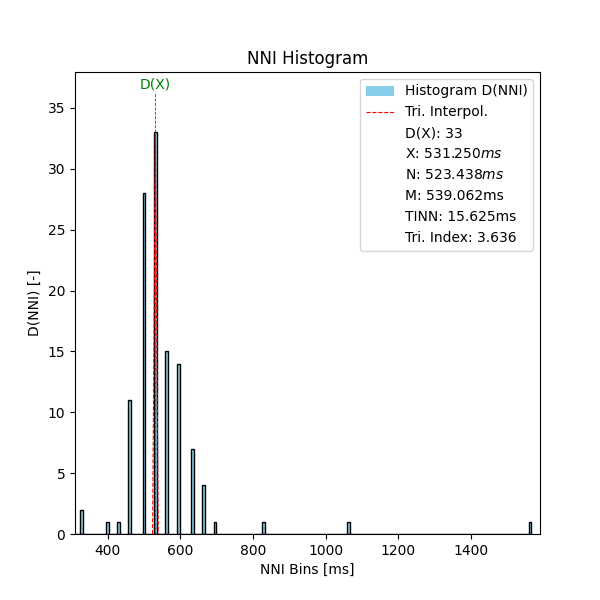

In [20]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from PIL import Image

data = np.load('../data/vid_results.npz')
with open('../data/hrv_result.pkl', 'rb') as f:
    hrv_result = pickle.load(f)

with open('../data/nni.pkl', 'rb') as file:
    nni_seq = pickle.load(file)

bvps = data['bvps']
timesES = data['timesES']
bpmES = data['bpmES']

nni_histogram_img = Image.open('../data/nni_histogram.png')
nni_histogram_img.show()

In [21]:
hrv_result

OrderedDict([('nni_counter', 120),
             ('nni_mean', 553.3333333333334),
             ('nni_min', 333.33000000000175),
             ('nni_max', 1566.6599999999999),
             ('hr_mean', 111.65753884657585),
             ('hr_min', 38.29803531078856),
             ('hr_max', 180.00180001799924),
             ('hr_std', 16.81089529174918),
             ('nni_diff_mean', 78.43201680672234),
             ('nni_diff_min', 0),
             ('nni_diff_max', 1066),
             ('sdnn', 124.00100152301778),
             ('sdnn_index', nan),
             ('sdann', nan),
             ('rmssd', 165.232111985208),
             ('sdsd', 146.04556634297504),
             ('nn50', 51),
             ('pnn50', 42.857142857142854),
             ('nn20', 91),
             ('pnn20', 76.47058823529412),
             ('tinn_n', 523.4375),
             ('tinn_m', 539.0625),
             ('tinn', 15.625),
             ('tri_index', 3.6363636363636362)])